# (12104) Chesley orbit determination test

In [1]:
import grss
prop = grss.prop
fit = grss.fit

In [2]:
import numpy as np
np.set_printoptions(precision=40, linewidth=np.inf)
import matplotlib.pyplot as plt

In [3]:
body_id = '12104'
init_sol, init_cov, nongrav_info = fit.get_sbdb_info(body_id)
body_radius = 0.0
de_kernel = 441
de_kernel_path = grss.utils.default_kernel_path(de_kernel)

In [4]:
add_gaia_obs = True
optical_obs_file = None
t_min_tdb = None
t_max_tdb = None
debias = False
debias_lowres = True
deweight = True
eliminate = False
max_obs_per_night = 4
verbose = True
obs_array_optical, observer_codes_optical = fit.get_mpc_optical_obs_array(body_id, optical_obs_file, t_min_tdb, t_max_tdb, debias, debias_lowres, deweight, eliminate, max_obs_per_night, verbose)
obs_array_radar, observer_codes_radar = fit.get_radar_obs_array(body_id, t_min_tdb, t_max_tdb, verbose)
if add_gaia_obs:
    obs_array_gaia, observer_codes_gaia = fit.get_gaia_optical_obs_array(body_id, de_kernel_path, t_min_tdb=None, t_max_tdb=None, verbose=True)
    obs_array_optical = np.vstack((obs_array_optical, obs_array_gaia))
    observer_codes_optical = observer_codes_optical + observer_codes_gaia

Skipped 28 observations 
	 28 of which were non-geocentric occultations or space-based observations, 
	 0 were either roving or radar observations (radar is handled separately), 
	 0 of which were outside the specified time range.
No debiasing needed for 1818 observations. Debiased 1273 observations. No biasing information for 10 observations.
Applied default weight of 1 arcsec to 149 CCD observations
Deweighted 799 observations as part of deweighting scheme.
Found 257 observations from Gaia DR3.
	 Added 32 of those observations.


In [5]:
n_iter_max = 10
fit_sim = fit.FitSimulation(init_sol, init_cov, obs_array_optical, observer_codes_optical, obs_array_radar, observer_codes_radar, n_iter_max=n_iter_max, de_kernel=de_kernel, de_kernel_path=de_kernel_path, radius=body_radius, nongrav_info=nongrav_info)

In [6]:
fit_sim.filter_lsq()

Iteration		Unweighted RMS		Weighted RMS 		Chi-squared		Reduced Chi-squared
1			 0.429			 0.491			 1431.855			 0.229
2			 0.429			 0.489			 1432.660			 0.229
3			 0.429			 0.489			 1432.660			 0.229
Converged without rejecting outliers. Starting outlier rejection now.
4			 0.401			 0.440			 1160.407			 0.186
5			 0.401			 0.438			 1160.997			 0.187
6			 0.401			 0.438			 1161.953			 0.187
Converged after rejecting outliers.


In [7]:
fit_sim.print_summary()

Summary of the orbit fit calculations at iteration 6 (of 6):
RMS unweighted: 0.40117357496421924
RMS weighted: 0.43778331934565284
chi-squared: 1161.9534903286312
reduced chi-squared: 0.1867491948454888
square root of reduced chi-squared: 0.4321448771482647
t: MJD 57746.0 TDB
Fitted Variable		Initial Value			Uncertainty			Fitted Value 			Uncertainty			Change				Change (sigma)
e			2.41655056825e-02		1.03214775617e-08 		2.41655363923e-02		1.06322925034e-08 		+3.07098014345e-08		+2.975
q			2.93824390646e+00		3.52512146316e-08 		2.93824381573e+00		3.59381068373e-08 		-9.07298169928e-08		-2.574
tp			5.68199329223e+04		1.12312890603e-04 		5.68199333169e+04		1.17439414620e-04 		+3.94599082938e-04		+3.513
om			7.80621908191e+01		3.44851294553e-07 		7.80621903822e+01		3.45442777238e-07 		-4.36980087670e-07		-1.267
w			1.82994396603e+02		2.01408146150e-05 		1.82994467905e+02		2.10441826297e-05 		+7.13022432706e-05		+3.540
i			1.11516090645e+01		2.01570918139e-07 		1.11516095724e+01		2.0270901374

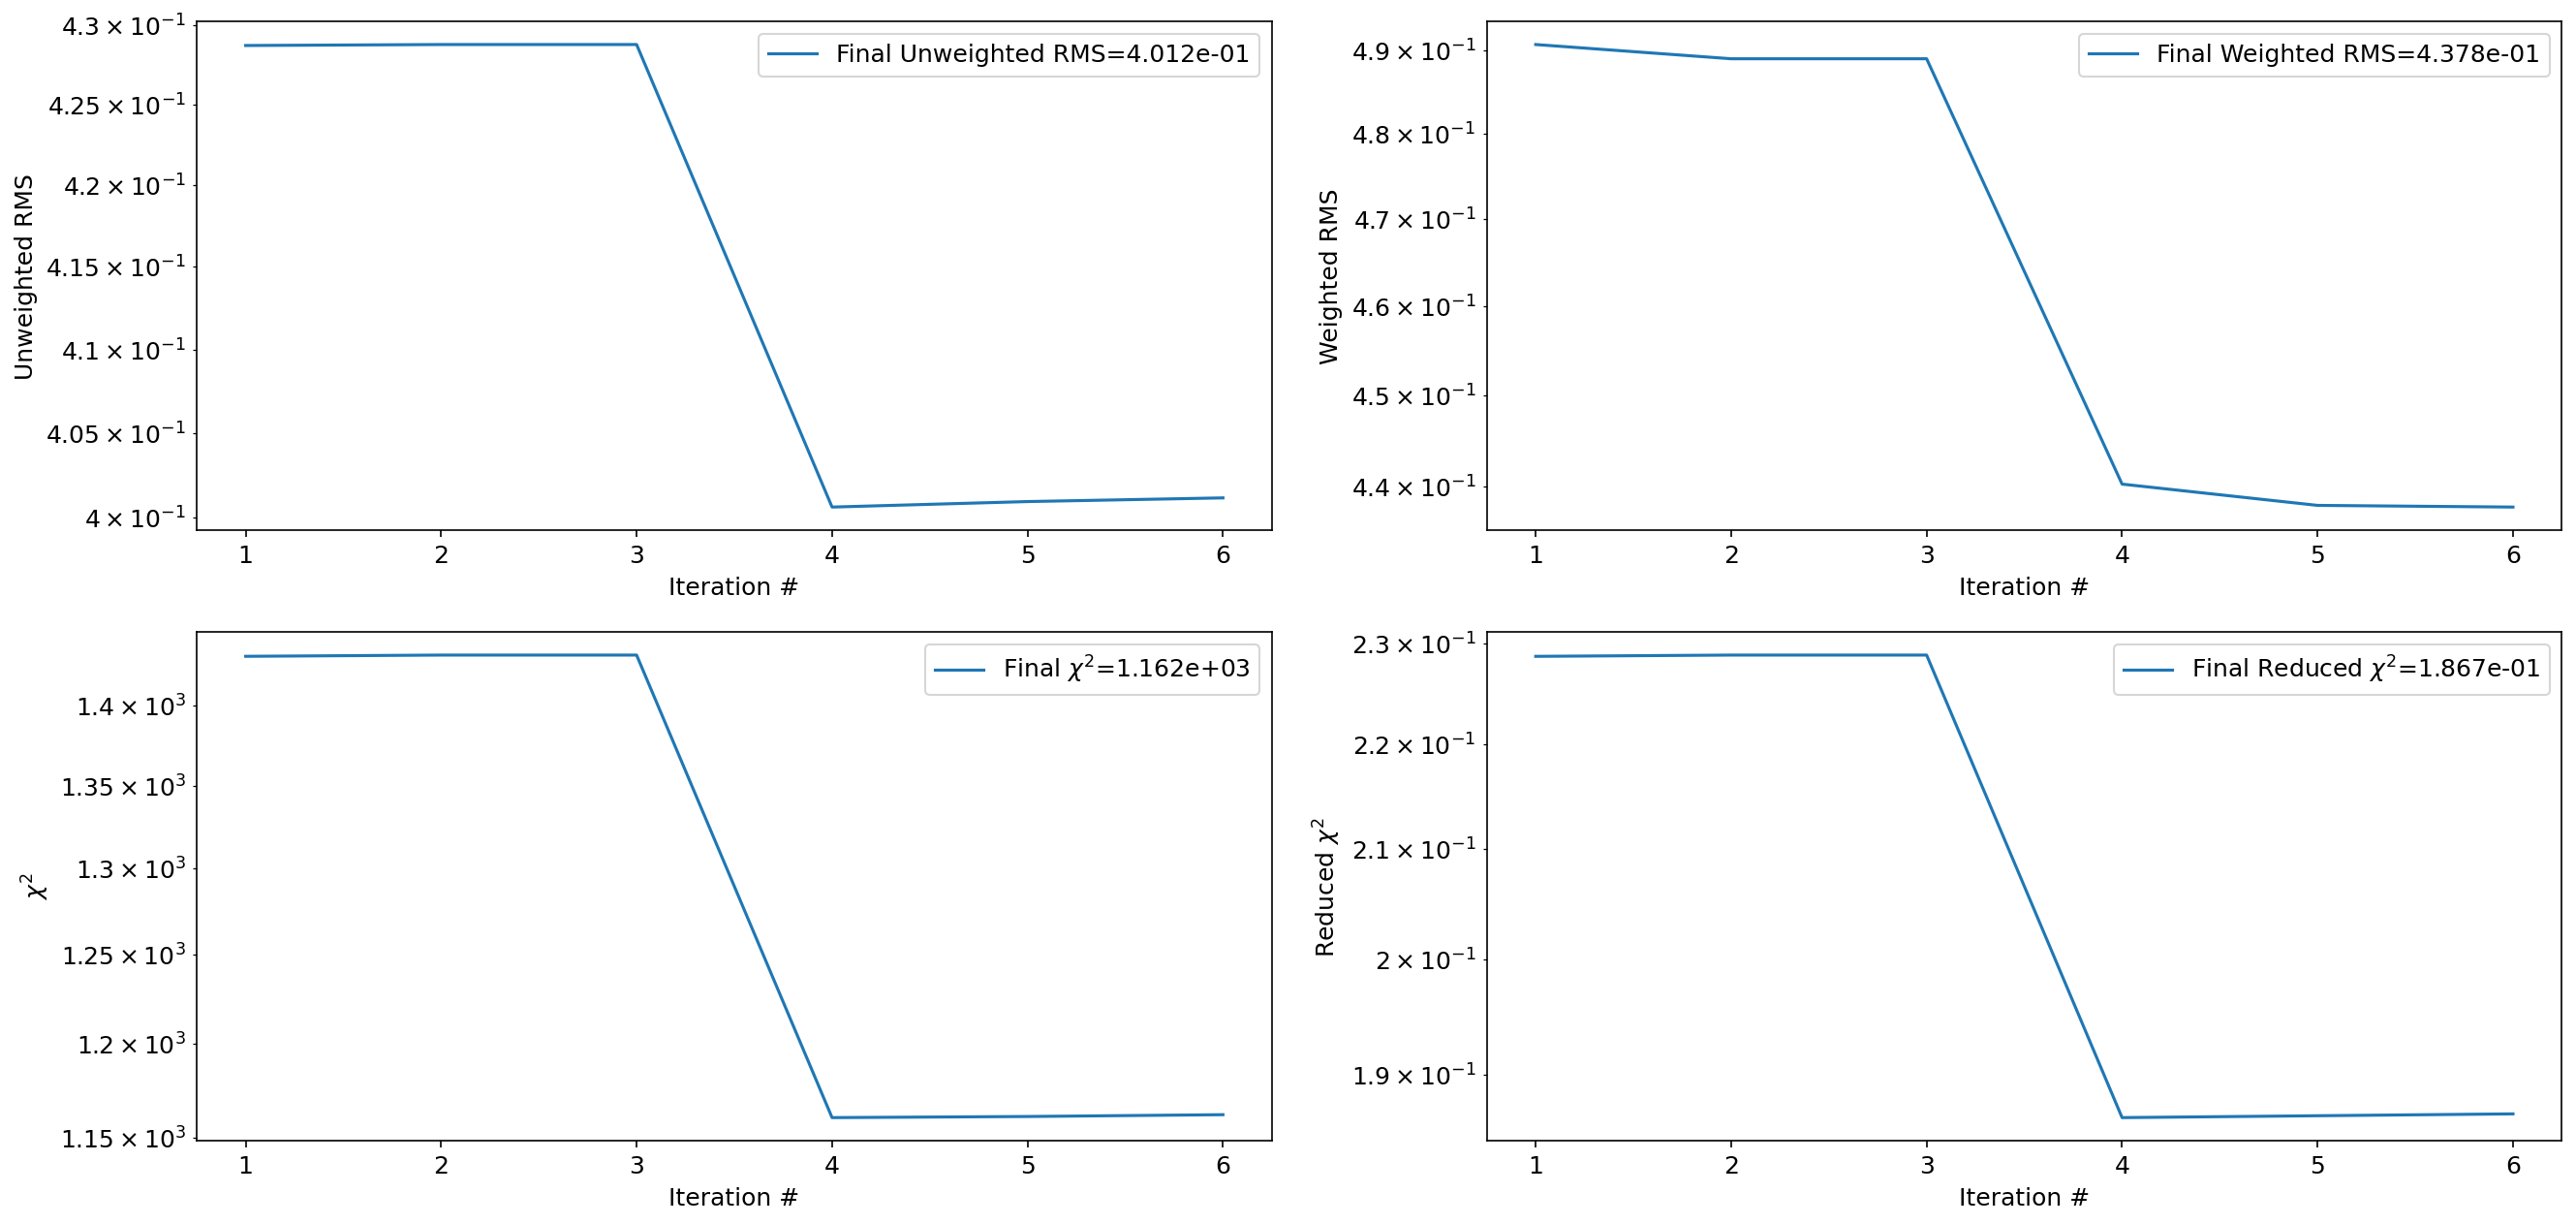

In [8]:
fit_sim.plot_summary(auto_close=True)

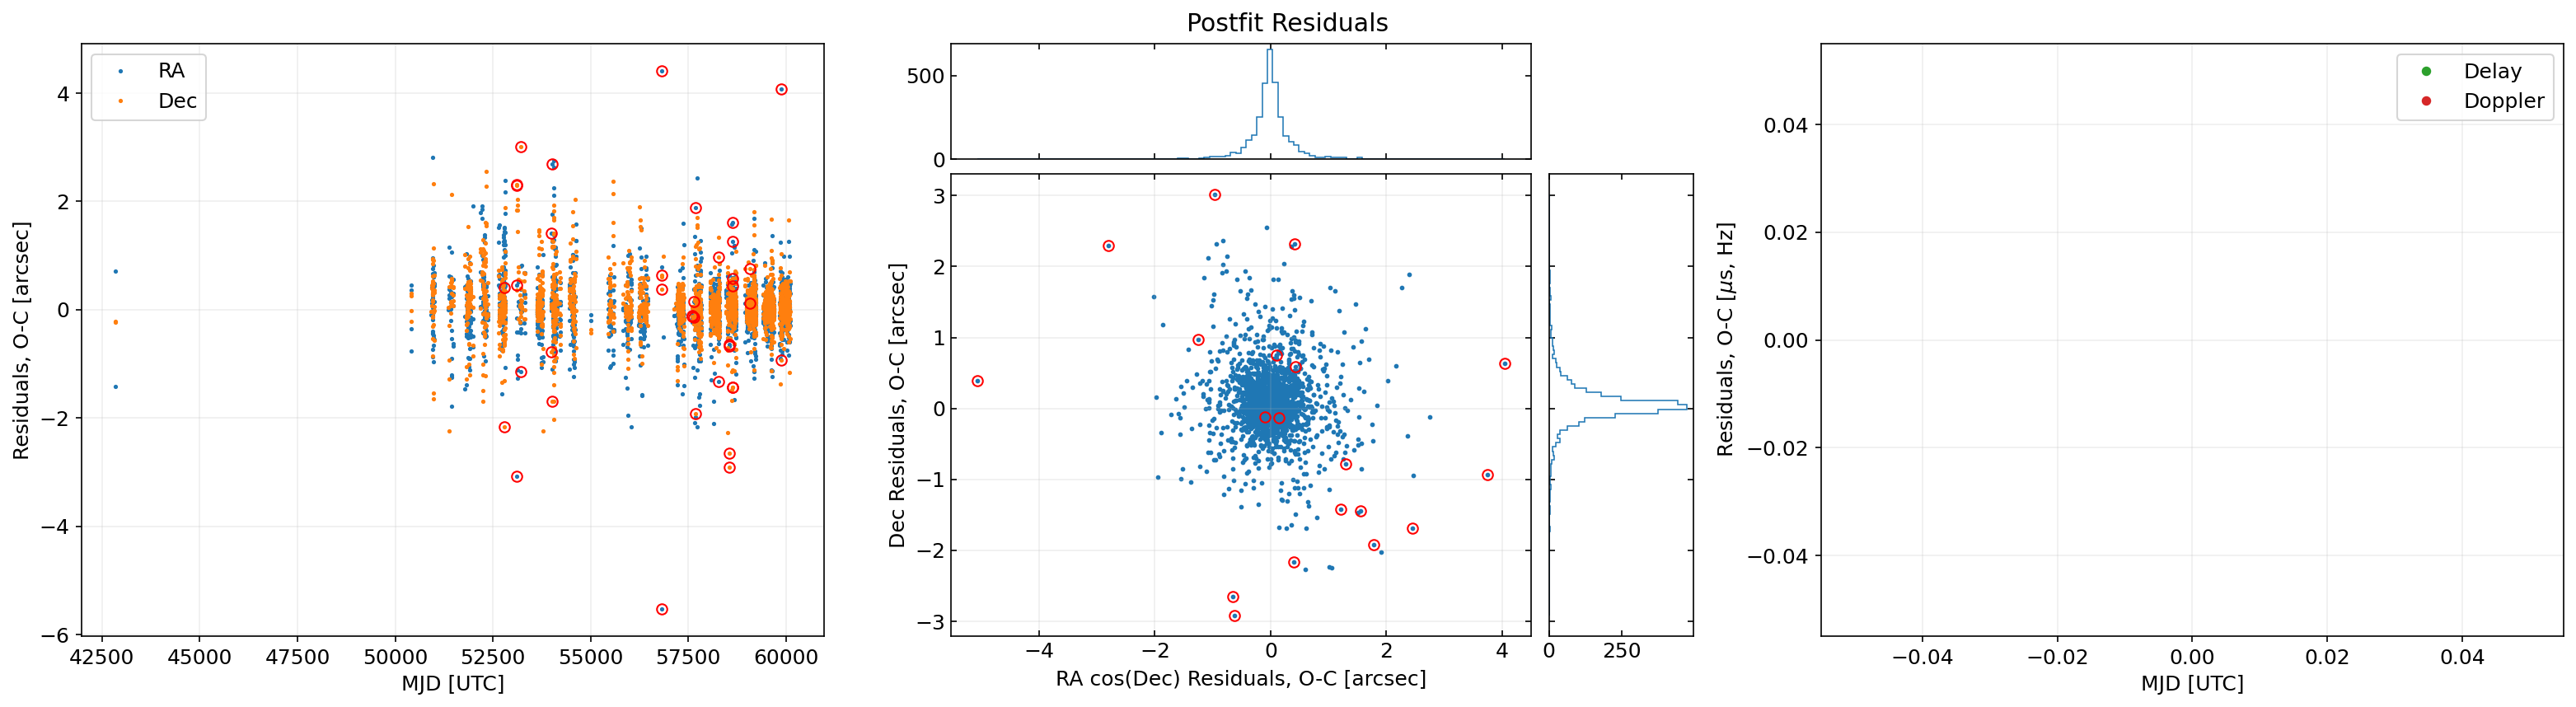

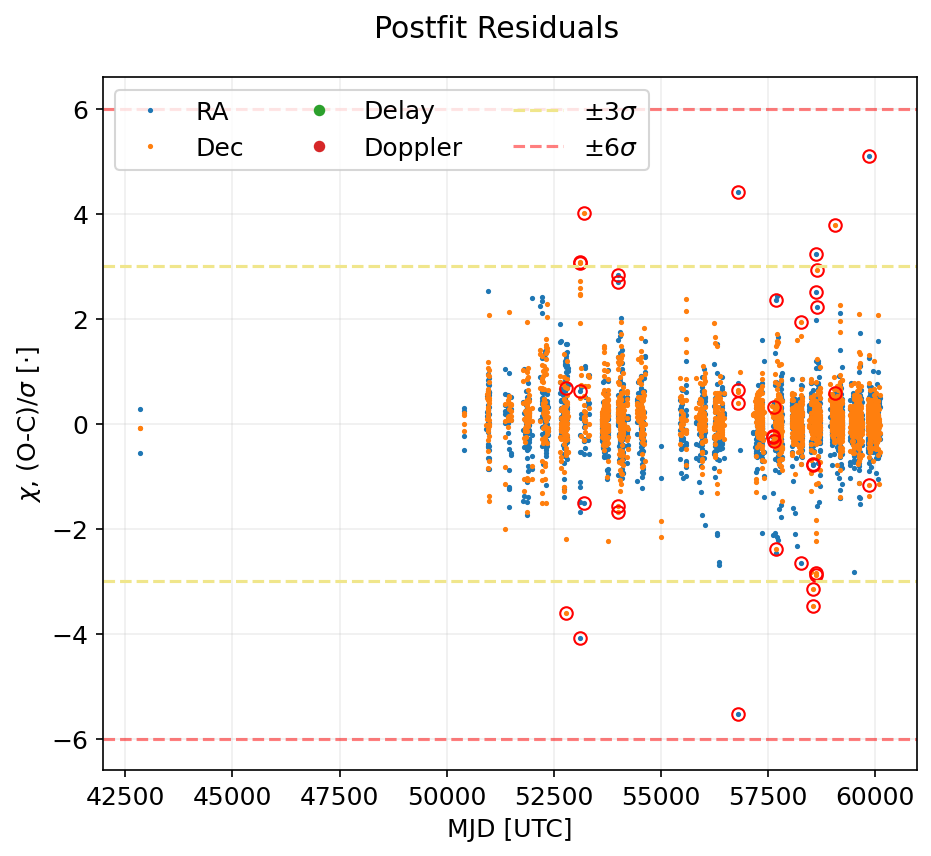

In [9]:
fit_sim.iters[-1].plot_iteration_summary(title='Postfit Residuals', auto_close=True)

In [10]:
mean_0 = np.array(list(init_sol.values())[1:])
cov_0 = init_cov
mean_f = np.array(list(fit_sim.x_nom.values()))
cov_f = fit_sim.covariance

maha_dist_f, maha_dist_0, bhattacharya, bhatt_coeff = fit.get_similarity_stats(mean_0, cov_0, mean_f, cov_f)
print(f'Mahalonobis distance between JPL and GRSS solution: {maha_dist_f:0.2f}')
print(f'Mahalonobis distance between GRSS and JPL solution: {maha_dist_0:0.2f}')
print(f'Bhattacharya distance between JPL and GRSS solution: {bhattacharya:0.4f}')
print(f'Bhattacharya coefficient between JPL and GRSS solution: {bhatt_coeff:0.4f}')

Mahalonobis distance between JPL and GRSS solution: 4.64
Mahalonobis distance between GRSS and JPL solution: 4.40
Bhattacharya distance between JPL and GRSS solution: 0.0040
Bhattacharya coefficient between JPL and GRSS solution: 0.9960


In [11]:
assert maha_dist_f < 5.0
assert maha_dist_0 < 5.0
assert bhattacharya < 0.10
assert bhatt_coeff > 0.90